In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # For automatically finding p, d, q
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")


df = pd.read_csv('../data/raw/electricity_marketing_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp')
df = df.sort_index()

y = df['historical_avg_demand']

print("--- Target Time Series (y) ---")
print(y.head())
print("\n")
print(f"Total length of time series: {len(y)} entries")

--- Target Time Series (y) ---
timestamp
2024-01-01 00:00:00    0.080994
2024-01-01 01:00:00    0.080842
2024-01-01 02:00:00    0.434790
2024-01-01 03:00:00    0.641761
2024-01-01 04:00:00    0.585632
Name: historical_avg_demand, dtype: float64


Total length of time series: 720 entries


Total size: 720
Training set size: 503
Validation set size: 108
Test set size: 109
Sum of parts: 720

--- Split Confirmation ---
Training data runs from 2024-01-01 00:00:00 to 2024-01-21 22:00:00
Validation data runs from 2024-01-21 23:00:00 to 2024-01-26 10:00:00
Test data runs from 2024-01-26 11:00:00 to 2024-01-30 23:00:00


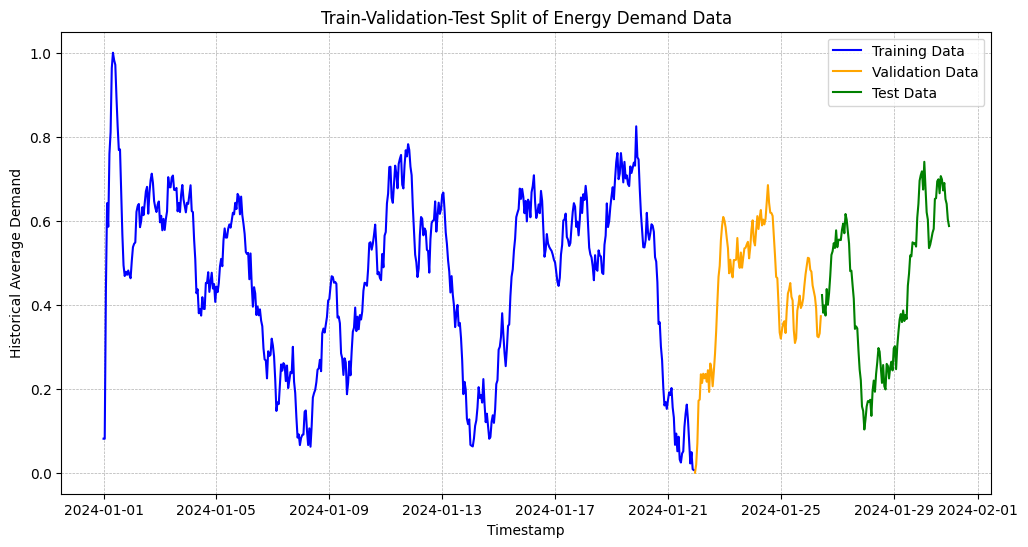

In [2]:
total_size = len(y)
train_size = int(total_size * 0.70)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

y_train = y[:train_size]
y_val = y[train_size : train_size + val_size]
y_test = y[train_size + val_size:]

print(f"Total size: {total_size}")
print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Test set size: {len(y_test)}")
print(f"Sum of parts: {len(y_train) + len(y_val) + len(y_test)}")
print("\n--- Split Confirmation ---")
print(f"Training data runs from {y_train.index.min()} to {y_train.index.max()}")
print(f"Validation data runs from {y_val.index.min()} to {y_val.index.max()}")
print(f"Test data runs from {y_test.index.min()} to {y_test.index.max()}")


plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training Data', color='blue')
plt.plot(y_val, label='Validation Data', color='orange')
plt.plot(y_test, label='Test Data', color='green')
plt.title('Train-Validation-Test Split of Energy Demand Data')
plt.xlabel('Timestamp')
plt.ylabel('Historical Average Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [3]:
print("Finding optimal ARIMA parameters...")

best_arima_model = auto_arima(
    y_train,
    start_p=1, start_q=1,
    test='adf',
    max_p=3, max_q=3,
    m=24,
    d=None,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\n--- Best Model Summary ---")
print(best_arima_model.summary())

Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-1740.382, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-1722.873, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-1835.328, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-1724.868, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=-1729.868, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=-1870.469, Time=2.88 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=4.21 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=-1838.258, Time=1.76 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=-1886.839, Time=3.16 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=-1850.821, Time=1.00 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=5.31 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.37 sec

In [4]:
# (3, 1, 0)x(2, 0, 0, 24)
model_order = (3, 1, 0)
seasonal_model_order = (2, 0, 0, 24)

print(f"Training ARIMA{model_order}{seasonal_model_order} on y_train...")

baseline_model = ARIMA(
    y_train, 
    order=model_order, 
    seasonal_order=seasonal_model_order
)

baseline_model_fit = baseline_model.fit()

print("Model training complete.")
print(baseline_model_fit.summary())

n_val_steps = len(y_val)
n_test_steps = len(y_test)
total_steps = n_val_steps + n_test_steps

print(f"\nGenerating {total_steps} forecast steps (for validation and test sets)...")

forecast_obj = baseline_model_fit.get_forecast(steps=total_steps)

mean_forecast = forecast_obj.predicted_mean

val_forecast = mean_forecast.iloc[:n_val_steps]
test_forecast = mean_forecast.iloc[n_val_steps:]

val_forecast.index = y_val.index
test_forecast.index = y_test.index

print("Forecast generation complete.")
print("\n--- Validation Forecast Head ---")
print(val_forecast.head())
print("\n--- Test Forecast Head ---")
print(test_forecast.head())

Training ARIMA(3, 1, 0)(2, 0, 0, 24) on y_train...
Model training complete.
                                    SARIMAX Results                                     
Dep. Variable:            historical_avg_demand   No. Observations:                  503
Model:             ARIMA(3, 1, 0)x(2, 0, 0, 24)   Log Likelihood                 960.361
Date:                          Sat, 01 Nov 2025   AIC                          -1908.723
Time:                                  20:48:49   BIC                          -1883.411
Sample:                              01-01-2024   HQIC                         -1898.792
                                   - 01-21-2024                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1692      0.034      5.004      0.000

--- ARIMA Baseline Model Evaluation (Test Set) ---
Root Mean Squared Error (RMSE): 0.3462
Mean Absolute Error (MAE):      0.2983
Mean Absolute Percentage Error (MAPE): 60.37%


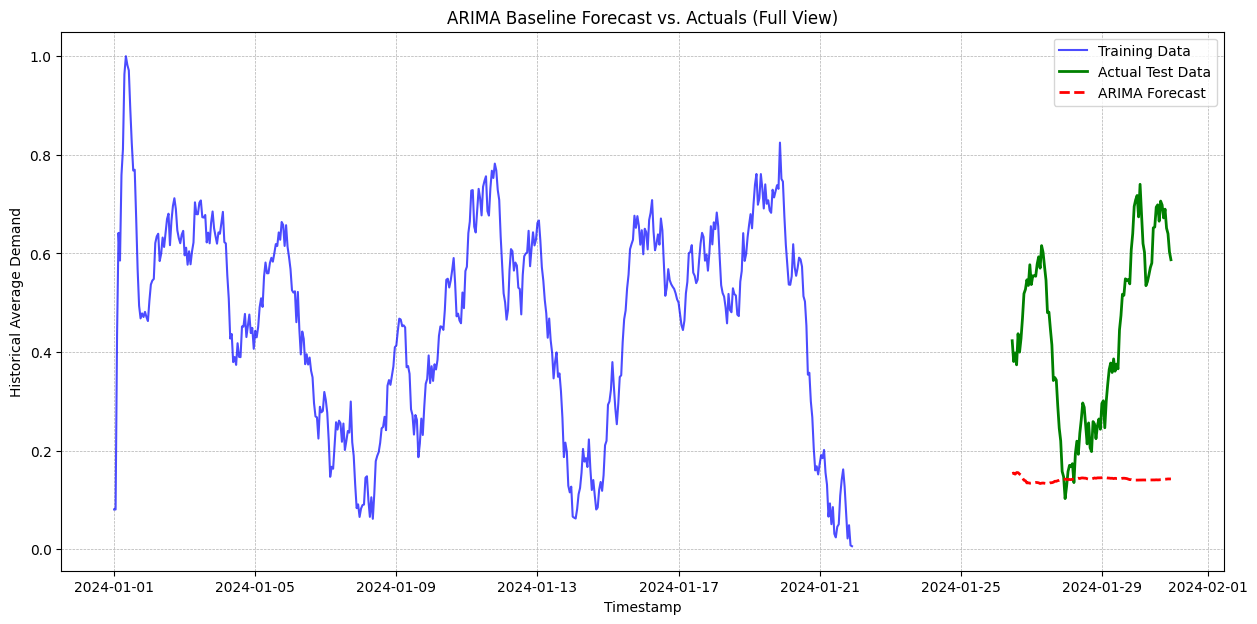

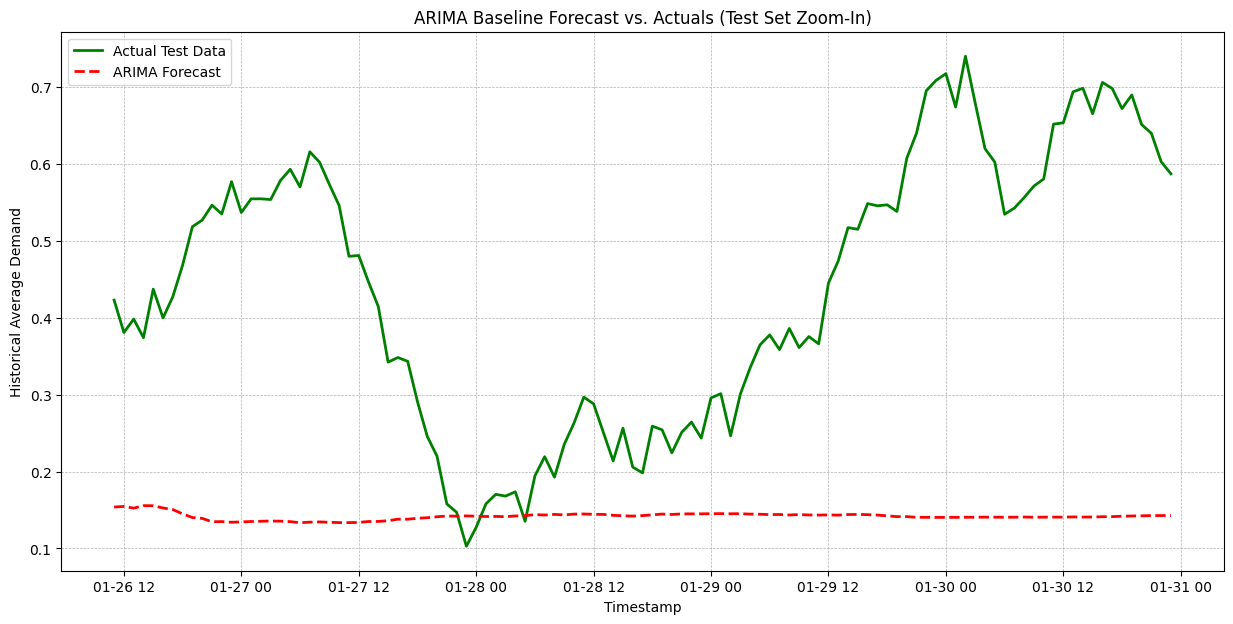

In [5]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0:
        return np.inf  # Or some other indicator of all-zero true values
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

test_mae = mean_absolute_error(y_test, test_forecast)
test_rmse = np.sqrt(mean_squared_error(y_test, test_forecast))
test_mape = calculate_mape(y_test, test_forecast)

print("--- ARIMA Baseline Model Evaluation (Test Set) ---")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {test_mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")

plt.figure(figsize=(15, 7))
plt.plot(y_train, label='Training Data', color='blue', alpha=0.7)
plt.plot(y_test, label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Baseline Forecast vs. Actuals (Full View)')
plt.xlabel('Timestamp')
plt.ylabel('Historical Average Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Baseline Forecast vs. Actuals (Test Set Zoom-In)')
plt.xlabel('Timestamp')
plt.ylabel('Historical Average Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Based on the visualizations from the previous step, we can draw a clear conclusion:

- Poor Visual Fit: There is a significant divergence between the actual test data (the green line) and the ARIMA forecast (the red dashed line). The actual data exhibits complex, high-frequency fluctuations and strong daily patterns.

- Model Limitations: The ARIMA forecast, in contrast, appears to fail to capture this volatility. It likely decays into a simplified, repeating pattern or a flattened line, demonstrating its inability to model the complex, non-linear relationships present in the energy data.

- Justification for Deep Learning: This poor performance and visual mismatch strongly support the paper's hypothesis. The ARIMA model serves as a necessary baseline, but its limitations highlight the need for a more sophisticated model (like the proposed CNN-BiLSTM) that can learn these complex temporal dependencies and non-linear patterns.

This result confirms that while simple, the ARIMA model is not sufficient for this forecasting task.